In [1]:
# #colabを使う方はこちらを使用ください。
# !pip install torch==0.4.1
# !pip install torchvision==0.2.1
# !pip install numpy==1.14.6
# !pip install matplotlib==2.1.2
# !pip install pillow==5.0.0
# !pip install opencv-python==3.4.3.18
# !pip install torchtext==0.3.1

    100% |████████████████████████████████| 519.5MB 31kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5918c000 @  0x7f11bb9112a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 2.3MB/s 
    100% |████████████████████████████████| 2.0MB 13.0MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
    100% |████████████████████████████████| 5.9MB 6.8MB/s 
  Found existing installation: Pillow 5.3.0
    Uninstalling Pillow-5.3.0:
      Successfully uninstalled Pillow-5.3.0
    100% |████████████████████████████████| 25.0MB 1.4MB/s 
  Found existing installation: opencv-python 3.4.4.19
    Uninstalling opencv-python-3.4.4.19:
      Successfully uninstalle

In [0]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
#torchtextを使用
from torchtext import data
from torchtext import vocab
from torchtext import datasets

%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

In [0]:
# データとモデルに.to(device)を指定してgpuの計算資源を使用する。
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# LSTMを使用した文章分類：IMDB

## データの読み込み

In [0]:
# ハイパーパラメータ
batch_size = 32 #バッチサイズ
output_size = 2 #fcの出力次元
hidden_size = 256 #lstmの出力次元
embedding_length = 300 #埋め込みベクトルの出力次元

In [0]:
# 前処理用の機能のFieldをセットアップ
# トークン化の方式を指定
tokenize = lambda x: x.split()
#Field
#include_lengths=Trueでイテレータが長さも含めたタプルを返す
#batch_first=Trueにしてる
TEXT = data.Field(sequential=True, tokenize=tokenize, lower=True, include_lengths=True, batch_first=True, fix_length=200)
#LabelField
LABEL = data.LabelField()
# IMDB映画レビューデータセット。映画レビューテキストデータとpositive, negativeのラベル。
# splitsでデータを分割
train_dataset, test_dataset = datasets.IMDB.splits(TEXT, LABEL)
train_dataset, val_dataset = train_dataset.split()

print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:06<00:00, 12.1MB/s]


17500
7500
25000


In [0]:
# build_vocabで単語の辞書を構築。IDと単語の一覧が作成されます。
# 学習済み埋め込みベクトルに適応
# min_freqで出現頻度の低い単語を省く。
TEXT.build_vocab(train_dataset, min_freq=3, vectors=vocab.GloVe(name='6B', dim=300))
LABEL.build_vocab(train_dataset)

# 単語の件数のtop10
print(TEXT.vocab.freqs.most_common(10))
# ラベルごと件数
print(LABEL.vocab.freqs)
# 単語
print(TEXT.vocab.itos[:10])
# BucketIteratorでバッチ単位にします。
train_iter, val_iter, test_iter = data.BucketIterator.splits((train_dataset, val_dataset, test_dataset), batch_size=32, sort_key=lambda x: len(x.text), repeat=False, shuffle=True)

#単語数
vocab_size = len(TEXT.vocab)
#埋め込みベクトル
word_embeddings = TEXT.vocab.vectors

[('the', 225379), ('a', 112117), ('and', 110728), ('of', 101083), ('to', 94064), ('is', 72993), ('in', 63363), ('i', 49107), ('this', 48899), ('that', 46326)]
Counter({'neg': 8797, 'pos': 8703})
['<unk>', '<pad>', 'the', 'a', 'and', 'of', 'to', 'is', 'in', 'i']


In [0]:
#データの確認
for i, batch in enumerate(train_iter):
    #バッチサイズ、単語列の長さ
    #バッチサイズ３２、data.Fieldでfix_length=200を指定したので200文字。
    print(batch.text[0].size())
    #ラベル
    print(batch.text[1].size())
    print(batch.label.size())
    print("１データ目の単語列を表示")
#     print(batch.text[0][0])
#     print(batch.text[1][0])
#     print(batch.label[0])
    print([TEXT.vocab.itos[data] for data in  batch.text[0][0].tolist()])
    print("ラベル")
    print(batch.label[0].item())
    break

torch.Size([32, 200])
torch.Size([32])
torch.Size([32])
１データ目の単語列を表示
['<unk>', 'movie', 'could', 'have', 'been', 'soooo', 'good!', 'all', 'generations', 'have', 'been', 'exposed', 'to', 'thunderbirds', 'and', 'have', 'come', 'to', 'love', 'it', 'and', 'this', 'film', 'had', 'some', 'of', 'the', 'features', 'one', 'would', 'look', 'for', 'in', 'a', 'good', 'thunderbirds', 'movie.', 'the', 'craft', 'themselves', 'and', 'tracey', 'island', 'were', 'realistically', 'transferred', 'to', 'the', 'big', 'screen,', 'whilst', 'still', 'keeping', 'to', 'the', 'designs', 'we', 'fell', 'in', 'love', 'with.', 'sophia', 'miles', 'was,', 'simply,', 'fantastic,', 'as', 'lady', 'p', 'and', 'bill', 'paxton,', 'whilst', 'not', 'exactly', 'who', 'i', '<unk>', 'jeff', 'tracey', 'being,', 'was', 'solid', '<unk>', 'then', 'the', 'adults', 'were', 'taken', 'out', 'of', 'the', 'equation', 'and', 'we', 'were', 'asked', 'to', 'believe', '8', 'year', 'olds', 'could', 'fly', '200', '<unk>', 'machines.<br', '/><br',

## ネットワークを定義

In [0]:
class LstmClassifier(nn.Module):
    def __init__(self, batch_size, hidden_size, output_size, vocab_size, embedding_length, weights):
        super(LstmClassifier, self).__init__()
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.vocab_size = vocab_size
        self.embed = nn.Embedding(vocab_size, embedding_length)
        #学習済みの埋め込みベクトルを使用
        self.embed.weight.data.copy_(weights)
        self.lstm = nn.LSTM(embedding_length, hidden_size, batch_first=True) #batch_first=Trueにしてる
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.embed(x)
        # 初期隠れ状態とセル状態を設定
        h0 = torch.zeros(1, self.batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(1, self.batch_size, self.hidden_size).to(device)
        # LSTMを伝播する
        # output_seqの出力形状：（バッチサイズ、シーケンス長、出力次元）
        output_seq, (h_n, c_n) = self.lstm(x, (h0, c0))        
        # 最後のタイムステップの隠れ状態をデコード
        out = self.fc(h_n[-1]) 
        return out

net = LstmClassifier(batch_size, hidden_size, output_size, vocab_size, embedding_length, word_embeddings)
net = net.to(device)


In [0]:
# 損失関数、最適化関数を定義
criterion = nn.CrossEntropyLoss()
optim = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()))

## 学習

In [0]:
num_epochs = 10

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    #train
    net.train()
    for i, batch in enumerate(train_iter):
      text = batch.text[0]
      text = text.to(device)
      if (text.size()[0] is not 32):
        continue
      labels = batch.label
      labels = labels.to(device)
      optim.zero_grad()
      outputs = net(text)
      loss = criterion(outputs, labels)
      train_loss += loss.item()
      train_acc += (outputs.max(1)[1] == labels).sum().item()
      loss.backward()
      optim.step()
    avg_train_loss = train_loss / len(train_iter.dataset)
    avg_train_acc = train_acc / len(train_iter.dataset)
    
    #val
    net.eval()
    with torch.no_grad():
      for batch in val_iter:
        text = batch.text[0]
        text = text.to(device)
        if (text.size()[0] is not 32):
          continue
        labels = batch.label
        labels = labels.to(device)
        outputs = net(text)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        val_acc += (outputs.max(1)[1] == labels).sum().item()
    avg_val_loss = val_loss / len(val_iter.dataset)
    avg_val_acc = val_acc / len(val_iter.dataset)
    
    print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}' 
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)


Epoch [1/10], Loss: 0.0215, val_loss: 0.0210, val_acc: 0.5712
Epoch [2/10], Loss: 0.0168, val_loss: 0.0147, val_acc: 0.8083
Epoch [3/10], Loss: 0.0121, val_loss: 0.0127, val_acc: 0.8351
Epoch [4/10], Loss: 0.0053, val_loss: 0.0127, val_acc: 0.8537
Epoch [5/10], Loss: 0.0016, val_loss: 0.0161, val_acc: 0.8460
Epoch [6/10], Loss: 0.0005, val_loss: 0.0202, val_acc: 0.8340
Epoch [7/10], Loss: 0.0002, val_loss: 0.0249, val_acc: 0.8371
Epoch [8/10], Loss: 0.0001, val_loss: 0.0281, val_acc: 0.8404
Epoch [9/10], Loss: 0.0001, val_loss: 0.0309, val_acc: 0.8397
Epoch [10/10], Loss: 0.0000, val_loss: 0.0295, val_acc: 0.8380


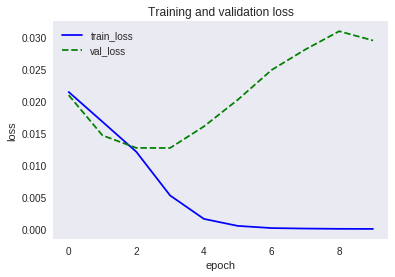

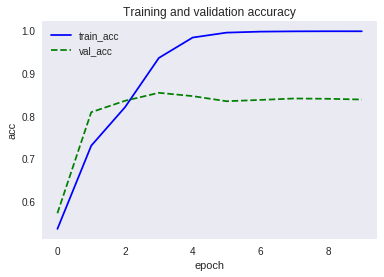

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()

## 推論

In [0]:
net.eval()
with torch.no_grad():
    total = 0
    test_acc = 0
    for batch in test_iter:
        text = batch.text[0]
        text = text.to(device)
        if (text.size()[0] is not 32):
          continue
        labels = batch.label
        labels = labels.to(device)

        outputs = net(text)
        test_acc += (outputs.max(1)[1] == labels).sum().item()
        total += labels.size(0)
    print('精度: {} %'.format(100 * test_acc / total)) 



精度: 81.22999359795135 %
